In [15]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs

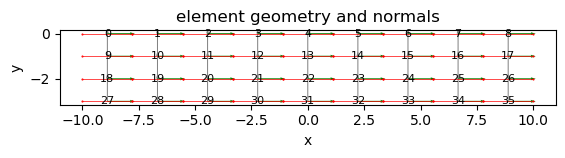

In [16]:
# Elastic parameter (shear modulus)
mu = 1.0
Lscale = 10
els_source = bemcs.initialize_els()
els_topo = bemcs.initialize_els()
els_b = bemcs.initialize_els()
els = bemcs.initialize_els()

# setup a fault geometry (source)
els_source.x1 = np.array([-1.0])
els_source.y1 = np.array([-0.5])
els_source.x2 = np.array([1.0])
els_source.y2 = np.array([-1.5])
bemcs.standardize_els_geometry(els_source, reorder=False)

# topography
xvals = np.linspace(-Lscale, Lscale, 10)
els_topo.x1 = xvals[0:-1]
els_topo.x2 = xvals[1:]
els_topo.y1 = np.zeros_like(els_topo.x1)
els_topo.y2 = np.zeros_like(els_topo.x1)
bemcs.standardize_els_geometry(els_topo, reorder=False)

# layered structure
zlayer = np.array([-1.0, -2.0, -3.0])
mulayer = np.array([1, 2, 3, 4.0])
npts_layer = 10
x1 = []
x2 = []
y1 = []
y2 = []
beta = np.ones(len(zlayer) * (npts_layer - 1))
for i in range(len(zlayer)):
    xvals = np.linspace(-Lscale, Lscale, npts_layer)
    x1 = np.hstack([x1, xvals[0:-1]])
    x2 = np.hstack([x2, xvals[1:]])
    y1 = np.hstack([y1, np.ones(npts_layer - 1) * zlayer[i]])
    y2 = np.hstack([y2, np.ones(npts_layer - 1) * zlayer[i]])
    beta[i * (npts_layer - 1) : (npts_layer - 1) * (i + 1)] = (
        mulayer[i + 1] - mulayer[i]
    ) / mulayer[i]
els_b.x1 = x1
els_b.x2 = x2
els_b.y1 = y1
els_b.y2 = y2
bemcs.standardize_els_geometry(els_b, reorder=False)

# combine topo and layered structure
els.x1 = np.hstack([els_topo.x1, els_b.x1])
els.x2 = np.hstack([els_topo.x2, els_b.x2])
els.y1 = np.hstack([els_topo.y1, els_b.y1])
els.y2 = np.hstack([els_topo.y2, els_b.y2])

# label topo index
topoindex = np.hstack(
    [np.ones(len(els_topo.x1), dtype=bool), np.zeros(len(els_b.x1), dtype=bool)]
)

bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)

bemcs.plot_els_geometry(els)

In [21]:
xo = els.x_centers
yo = els.y_centers
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_slip_antiplane(
    xo, yo, els_source, mu
)
quadcoefs = np.ones(3)

# compute strain due to source at els
ex0 = K_sx @ quadcoefs
ey0 = K_sy @ quadcoefs

# compute els force kernels
K_sx, K_sy, _ = bemcs.get_displacement_stress_kernel_force_antiplane(xo, yo, els, mu)
# construct constant kernels from linear kernels for this simple example
K_x = np.zeros((n_els, n_els))
K_y = np.zeros((n_els, n_els))
for i in range(n_els):
    K_x[:, i] = K_sx[:, 2 * i] + K_sx[:, 2 * i + 1]
    K_y[:, i] = K_sy[:, 2 * i] + K_sy[:, 2 * i + 1]

betamat = np.repeat(beta.reshape(-1, 1), len(els_b.x1), axis=1)
kernel = np.vstack(
    [
        np.hstack([K_y[topoindex][:, topoindex], K_y[topoindex][:, ~topoindex]]),
        np.hstack(
            [
                -betamat @ K_y[~topoindex][:, topoindex],
                np.eye(len(els_b.x1)) - betamat @ K_y[~topoindex][:, ~topoindex],
            ]
        ),
    ]
)

# solve system to get body forces
solvec = np.linalg.inv(kernel) @ np.vstack(
    [-ey0[topoindex].reshape(-1, 1), (beta * ey0[~topoindex]).reshape(-1, 1)]
)